## In this notebook

- Create a memory base model.
- Overall goal of the task: Predict electronic vehicles charging stations availability in Paris.
- There are four target columns:
    - `Available`: how many plugs are available at time t for the station k,
    - `Charging`: how many plugs are occupied and charging at time t for the station k,
    - `Passive`: how many plugs are occupied but not charging at time t for the station k,
    - `Other`: how many plugs are either offline or out of order at time t for the station k.

In [1]:
import os

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# model
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score, 
    top_k_accuracy_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
DATA_FOLDER = "../data"

DAYS_IN_TEST_SET = 7 * 4

Y_COLUMN = "available"
X_COLUMNS = [
    "tod",
    "dow",
    "latitude",
    "longitude",
    "postcode",
    "area",
]
TIMESTEP = 4

# random test stations
STATIONS_FOR_TEST = [
    "FR*V75*EBELI*99*1", 
    "FR*V75*EBELI*98*1"
]

In [4]:
! ls -l $DATA_FOLDER

total 183164
-rw-r--r-- 1 nobody nogroup    570468 Nov 28 10:44 20221128104433_submissions.zip
-rw-r--r-- 1 nobody nogroup    562307 Nov 28 14:03 20221128140318_submissions.zip
-rw-r--r-- 1 nobody nogroup    562307 Nov 28 14:16 20221128141653_submissions.zip
drwxr-xr-x 5 nobody nogroup       160 Nov 28 10:06 submissions
-rw-rw-r-- 1 nobody nogroup  14095077 Aug  4 08:41 test.csv
-rw-rw-r-- 1 nobody nogroup 171754453 Aug  4 08:41 train.csv


## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df.columns = [col.lower() for col in df.columns]

df.tail()

,date,station,available,charging,passive,other,tod,dow,trend,latitude,longitude,postcode,area
1851078,2021-02-18 23:45:00,FR*V75*EBELI*95*1,0,0,0,3,95,5,22202,48.86851,2.295469,75016,west
1851079,2021-02-18 23:45:00,FR*V75*EBELI*96*1,2,1,0,0,95,5,22202,48.83550,2.349650,75013,south
1851080,2021-02-18 23:45:00,FR*V75*EBELI*97*1,1,1,1,0,95,5,22202,48.83995,2.397822,75012,east
1851081,2021-02-18 23:45:00,FR*V75*EBELI*98*1,2,0,1,0,95,5,22202,48.84998,2.361920,75004,south
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.87780,2.391820,75019,east


In [6]:
# leave only one target - "available" - in the data set

df = df.drop(["charging", "passive", "other"], axis=1)

## Process data

In [7]:
# add history

# work only with subsample to save time
df = (
    df
    .loc[df.station.isin(STATIONS_FOR_TEST)]
    .reset_index(drop=True)
)

for i in range(1, TIMESTEP + 1):
    col_name = f"{Y_COLUMN}_prev_{i}"

    df[col_name] = (
        df
        .groupby(["station"])["available"]
        .shift(i)
    )
    
    X_COLUMNS.append(col_name)

In [8]:
# delete NaNs

df = df.dropna().reset_index(drop=True)

In [9]:
# split data into X and y

df["date"] = pd.to_datetime(df.date)
df = df.sort_values(by=["date"]).reset_index(drop=True)

last_train_set_datetime = df.date.max() - pd.Timedelta(days=DAYS_IN_TEST_SET)

X_train = df.loc[df.date <= last_train_set_datetime, X_COLUMNS]
y_train = df.loc[df.date <= last_train_set_datetime, Y_COLUMN]
X_test = df.loc[df.date > last_train_set_datetime, X_COLUMNS]
y_test = df.loc[df.date > last_train_set_datetime, Y_COLUMN]


print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(38672, 10)
y_train.shape=(38672,)
X_test.shape=(5342, 10)
y_test.shape=(5342,)


## Build model

In [10]:
# define categorical transformers

cols_categorical = [
    "postcode",
    "area",
]

transformers_categorical = Pipeline(
    steps=[
        # ("ordinal_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=999))
        ("ordinal_encoder", OrdinalEncoder())
    ]
)

In [11]:
# define coordinates transformers

cols_coordinates = [
    "latitude",
    "longitude",
]

transformers_coordinates = Pipeline(
    steps=[
        ("min_max_scaler", MinMaxScaler())
    ]
)

In [12]:
%%time

# define and fit pipeline

transformers = ColumnTransformer(
    transformers=[
        ("categorical", transformers_categorical, cols_categorical),
        ("coordinates", transformers_coordinates, cols_coordinates),
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("transformers", transformers),
    ("model", GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

CPU times: user 5.82 s, sys: 4.31 ms, total: 5.82 s
Wall time: 5.82 s


Pipeline(steps=[('transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['postcode', 'area']),
                                                 ('coordinates',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['latitude', 'longitude'])])),
                ('model', GradientBoostingClassifier())])

In [13]:
# check performance on test dataset

y_test_pred = pipeline.predict(X_test)
y_test_pred_probas = pipeline.predict_proba(X_test)

print("Results:")
print(f"- accuracy: {accuracy_score(y_test, y_test_pred):,.3f}")
print(f"- precision: {precision_score(y_test, y_test_pred, average='weighted', zero_division=0):,.3f}")
print(f"- recall: {recall_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- F1: {f1_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- accuracy (top k=2): {top_k_accuracy_score(y_test, y_test_pred_probas, k=2):,.3f}")
print()
print(f"- confusion matrix: \n{confusion_matrix(y_test, y_test_pred)}")

Results:
- accuracy: 0.883
- precision: 0.881
- recall: 0.883
- F1: 0.881
- accuracy (top k=2): 0.973

- confusion matrix: 
[[  11    7    7   33]
 [   6  206   78   10]
 [   1   80 1105  196]
 [   1    7  197 3397]]


<AxesSubplot: >

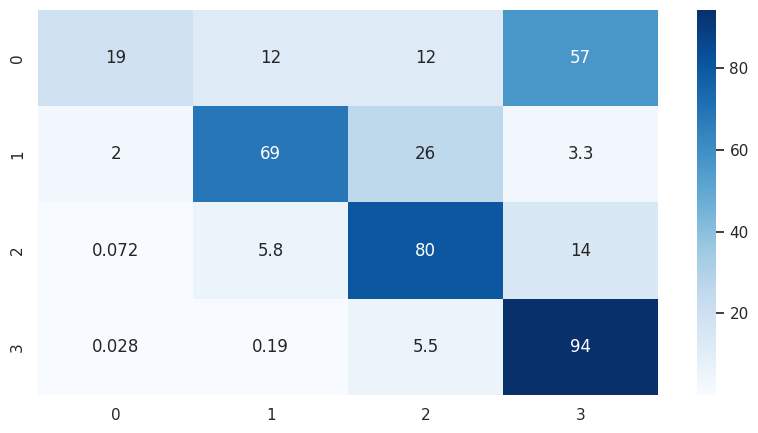

In [14]:
# check confusion matrix (with shares in every true class=rows)

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm / cm.sum(axis=1).reshape(-1, 1) * 100, 
    annot=True,
    # fmt='g',
    cmap='Blues',
)

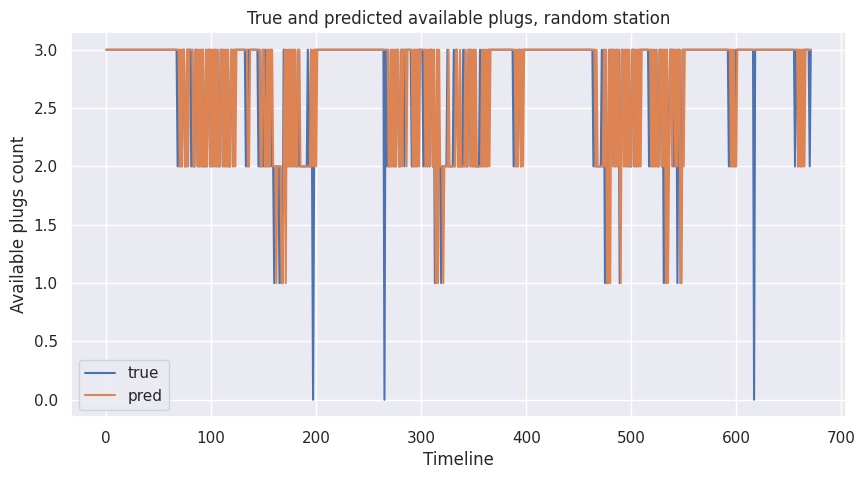

In [15]:
# check comparison of true and predicted available plugs

df_results = pd.DataFrame({
    "true": y_test.values,
    "pred": y_test_pred,
})

# ax = df_results.plot(alpha=0.75)
ax = df_results.head(DAYS_IN_TEST_SET * 24).plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs count")
ax.set_title("True and predicted available plugs, random station")

plt.show()

## Get predictions

#### Load test data

In [16]:
# load test data

df_test = pd.read_csv(os.path.join(DATA_FOLDER, "test.csv")).drop(["trend"], axis=1)
df_test["date"] = pd.to_datetime(df_test["date"])
df_test.columns = [col.lower() for col in df_test.columns]

# work only with subsample to save time
df_test = (
    df_test
    .loc[df_test.station.isin(STATIONS_FOR_TEST)]
    .reset_index(drop=True)
)

df_test.tail()

,date,station,tod,dow,latitude,longitude,postcode,area
3643,2021-03-10 23:15:00,FR*V75*EBELI*99*1,93,4,48.87780,2.39182,75019,east
3644,2021-03-10 23:30:00,FR*V75*EBELI*98*1,94,4,48.84998,2.36192,75004,south
3645,2021-03-10 23:30:00,FR*V75*EBELI*99*1,94,4,48.87780,2.39182,75019,east
3646,2021-03-10 23:45:00,FR*V75*EBELI*98*1,95,4,48.84998,2.36192,75004,south
3647,2021-03-10 23:45:00,FR*V75*EBELI*99*1,95,4,48.87780,2.39182,75019,east


In [17]:
# add missing day -> 2021-02-23

df_missing_day = (
    df_test
    .loc[df_test.date.between(pd.to_datetime("2021-02-22"), pd.to_datetime("2021-02-23"))]
    .copy()
)
df_missing_day["date"] = (pd.to_datetime(df_missing_day["date"]) + pd.Timedelta(days=1))
df_missing_day["dow"] = df_missing_day.dow + 1

df_test = (
    pd
    .concat([df_test, df_missing_day], ignore_index=True)
    .sort_values(by="date")
    .reset_index(drop=True)
)

df_test.tail()

,date,station,tod,dow,latitude,longitude,postcode,area
3835,2021-03-10 23:15:00,FR*V75*EBELI*99*1,93,4,48.87780,2.39182,75019,east
3836,2021-03-10 23:30:00,FR*V75*EBELI*98*1,94,4,48.84998,2.36192,75004,south
3837,2021-03-10 23:30:00,FR*V75*EBELI*99*1,94,4,48.87780,2.39182,75019,east
3838,2021-03-10 23:45:00,FR*V75*EBELI*99*1,95,4,48.87780,2.39182,75019,east
3839,2021-03-10 23:45:00,FR*V75*EBELI*98*1,95,4,48.84998,2.36192,75004,south


In [18]:
# get date boundaries 

test_min_date = df_test.date.min()
test_max_date = df_test.date.max()

In [19]:
# prepare df_preds

dfs = []

for station in df_test.station.unique():
    dfs.append(
        df
        .loc[df.station == station]
        .sort_values(by="date")
        .tail(TIMESTEP * 2)
        .drop(["trend"], axis=1)
    )

df_preds = (
    pd
    .concat(dfs, ignore_index=True)
    .reset_index(drop=True)
    # .drop(["available_prev_1", "available_prev_2", "available_prev_3", "available_prev_4"], axis=1)
)

df_preds["date"] = pd.to_datetime(df_preds.date)
df_preds.tail()

,date,station,available,tod,dow,latitude,longitude,postcode,area,available_prev_1,available_prev_2,available_prev_3,available_prev_4
11,2021-02-18 22:45:00,FR*V75*EBELI*99*1,2,91,5,48.8778,2.39182,75019,east,2.0,2.0,1.0,1.0
12,2021-02-18 23:00:00,FR*V75*EBELI*99*1,3,92,5,48.8778,2.39182,75019,east,2.0,2.0,2.0,1.0
13,2021-02-18 23:15:00,FR*V75*EBELI*99*1,3,93,5,48.8778,2.39182,75019,east,3.0,2.0,2.0,2.0
14,2021-02-18 23:30:00,FR*V75*EBELI*99*1,3,94,5,48.8778,2.39182,75019,east,3.0,3.0,2.0,2.0
15,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,95,5,48.8778,2.39182,75019,east,3.0,3.0,3.0,2.0


In [20]:
%%time

# get predictions

for date in pd.date_range(start=test_min_date, end=test_max_date, freq="15min"):
    
    df_preds = pd.concat(
        [
            df_preds,
            df_test.loc[df_test.date == date].copy()
        ], 
        axis=0
    )
    
    # compute previous values
    for i in range(1, TIMESTEP + 1):
        col_name = f"{Y_COLUMN}_prev_{i}"

        df_preds[col_name] = (
            df_preds
            .groupby(["station"])["available"]
            .shift(i)
            .fillna(0)
        )
    
    # get predictions
    preds = pipeline.predict(df_preds[X_COLUMNS])
    df_preds["available"] = df_preds.available.mask(df_preds.available.isna(), preds)

print(df_preds.shape)
df_preds.tail()

(3856, 13)
CPU times: user 14.1 s, sys: 12.8 ms, total: 14.1 s
Wall time: 14.1 s


,date,station,available,tod,dow,latitude,longitude,postcode,area,available_prev_1,available_prev_2,available_prev_3,available_prev_4
3835,2021-03-10 23:15:00,FR*V75*EBELI*99*1,3.0,93,4,48.87780,2.39182,75019,east,3.0,3.0,3.0,3.0
3836,2021-03-10 23:30:00,FR*V75*EBELI*98*1,2.0,94,4,48.84998,2.36192,75004,south,2.0,2.0,2.0,2.0
3837,2021-03-10 23:30:00,FR*V75*EBELI*99*1,3.0,94,4,48.87780,2.39182,75019,east,3.0,3.0,3.0,3.0
3838,2021-03-10 23:45:00,FR*V75*EBELI*99*1,3.0,95,4,48.87780,2.39182,75019,east,3.0,3.0,3.0,3.0
3839,2021-03-10 23:45:00,FR*V75*EBELI*98*1,2.0,95,4,48.84998,2.36192,75004,south,2.0,2.0,2.0,2.0


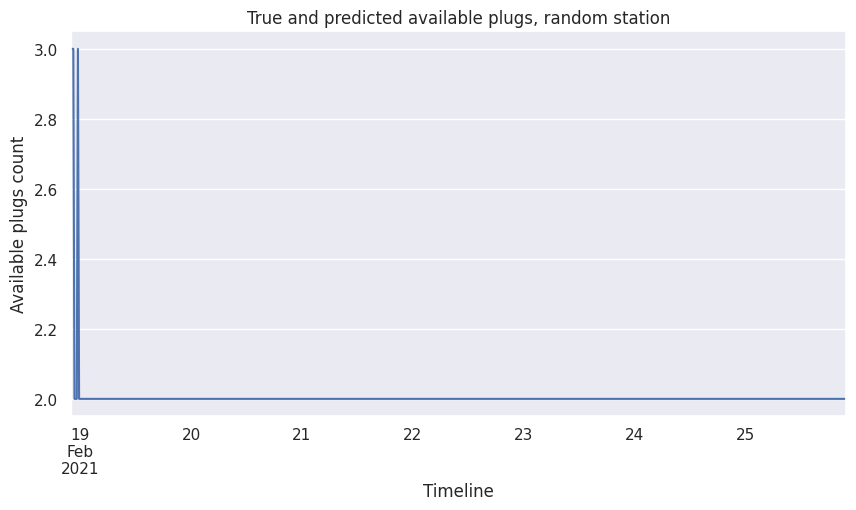

In [21]:
ax = (
    df_preds
    .sort_values(by=["station", "date"])
    .set_index("date")
    .head(DAYS_IN_TEST_SET * 24)
    .available
    .plot()
)

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs count")
ax.set_title("True and predicted available plugs, random station")

plt.show()

In [22]:
df_preds.station.unique()

array(['FR*V75*EBELI*98*1', 'FR*V75*EBELI*99*1'], dtype=object)

In [23]:
(
    df_preds
    .loc[
        (df_preds.station == "FR*V75*EBELI*99*1") &
        (df_preds.date >= test_min_date)
    ]
    .available
    .value_counts()
)

3.0    1920
Name: available, dtype: int64

## Results

- Created a model, unfortunately, it doesn't have any memory...